In [12]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2

from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\su.osmond\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\su.osmond\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **Load Data**

In [19]:
# Load the cleaned datasets
df_user_inputs = pd.read_csv('../dataset//user_inputs_cleaned.csv')
df_labels = pd.read_csv('../dataset//labels_cleaned.csv')

# Ensure alignment
assert len(df_labels) == len(df_user_inputs), "Datasets do not align!"

print(df_user_inputs.shape)
df_user_inputs.head(10)

(3974, 2)


,Unnamed: 0,text
0,0,er is een teek op mijn been ik ben bang dat di...
1,1,er is een teek op mijn rug en ik krijg hem er ...
2,2,op mijn been zit een teek ik heb hem geprobeer...
3,3,ik heb allergieen
4,4,huid
5,5,roodheid
6,6,schilfering
7,7,ik heb wratten onder mijn voet
8,8,ik heb gisteren naar het bos geweest en zie nu...
9,9,ik voelde iets prikken


In [20]:
# Determine model baseline
label_frequencies = df_labels.sum().sort_values(ascending=False)
label_frequencies / df_labels.shape[0]

Unnamed: 0                                           1986.500000
Huidklachten                                            0.088827
Beenklachten                                            0.072723
Buikpijn                                                0.062154
Oorklachten                                             0.052843
                                                        ...     
Liesklachten                                            0.005033
Pijnlijke mondhoeken of kloofjes in de mondhoeken       0.005033
Tekenbeet                                               0.005033
Enkelklachten                                           0.005033
Niet lekker voelen, algehele malaise                    0.002516
Length: 75, dtype: float64

We see that if we predict every time the label with the highest frequency (Huidklachten), our model will be correct around 9% of the time. We want our model to perform at least better than this 9% threshold

## **Preprocess Data**

In [6]:
# Preprocess user input text
# could be better and more advanced
def preprocess_text(text):
    """
    Preprocesses the input text by converting to lowercase and removing special characters.
    Args:
        text (str): The text to preprocess.
    Returns:
        str: The preprocessed text.
    """

    # Convert to lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'\W+', ' ', text)
    return text

df_user_inputs['text'] = df_user_inputs['text'].apply(preprocess_text)

df_user_inputs.head()

,text
0,er is een teek op mijn been ik ben bang dat di...
1,er is een teek op mijn rug en ik krijg hem er ...
2,op mijn been zit een teek ik heb hem geprobeer...
3,ik heb allergieen
4,huid


## **Prepare Data to Model Format**

We changed the process of splitting the dataset into train/val/test sets, to accomodate the nature of multi-label classification. Instead of using a traditional method, we employ iterative stratified sampling `iterative_train_test_split`, to provide a well-balanced distribution of all label combinations in both training and test sets.

In [10]:
## Split data to train:val:test

# Prepare data for iterative train test split
# X must be 2D np.ndarray and y must be 2D binary np.ndarray
X_texts = df_user_inputs['text'].values
X_texts = X_texts.reshape(-1, 1)
y = df_labels.values

# Split the data 60:20:20 with multi-label stratification
train_texts, y_train, test_texts, y_test = iterative_train_test_split(X_texts, y, test_size = 0.2)
#val_texts, y_val, test_texts, y_test = iterative_train_test_split(tmp_texts, y_tmp, test_size = 0.5)

# Sanity checks to confirm the shapes of the datasets
assert train_texts.shape[0] == y_train.shape[0], "Mismatch in train data and labels"
assert test_texts.shape[0] == y_test.shape[0], "Mismatch in test data and labels"

train_texts, test_texts = train_texts.ravel(), test_texts.ravel()
#val_texts = val_texts.ravel()

print(train_texts.shape, y_train.shape, test_texts.shape)
train_texts

(3175,) (3175, 74) (799,)


array(['er is een teek op mijn been ik ben bang dat die er al een tijdje op heeft gezeten',
       'ik heb allergieen', 'roodheid', ...,
       'vannacht met slapen denk ik gekke beweging gemaakt want mn nek is nu helemaal stijf kan niet meer naar rechts kijken',
       'heb al langere tijd pijn in mn nek krijg dan soms tintelingen over mijn arm heb dan ook minder kracht in mijn arm',
       'doet zeer als ik mn hoofd beweeg'], dtype=object)

In [11]:
## Vectorize our text data

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and Transform the Training Data
X_train = vectorizer.fit_transform(train_texts)

# We only transform, rather than fit_transform on val and test sets, to avoid data leakage
#X_val = vectorizer.transform(val_texts)
X_test = vectorizer.transform(test_texts)

# Convert arrays from sparse to dense
X_train, X_test = X_train.toarray(), X_test.toarray()
#X_val = X_val.toarray()

X_train.shape, X_test.shape

((3175, 5000), (799, 5000))

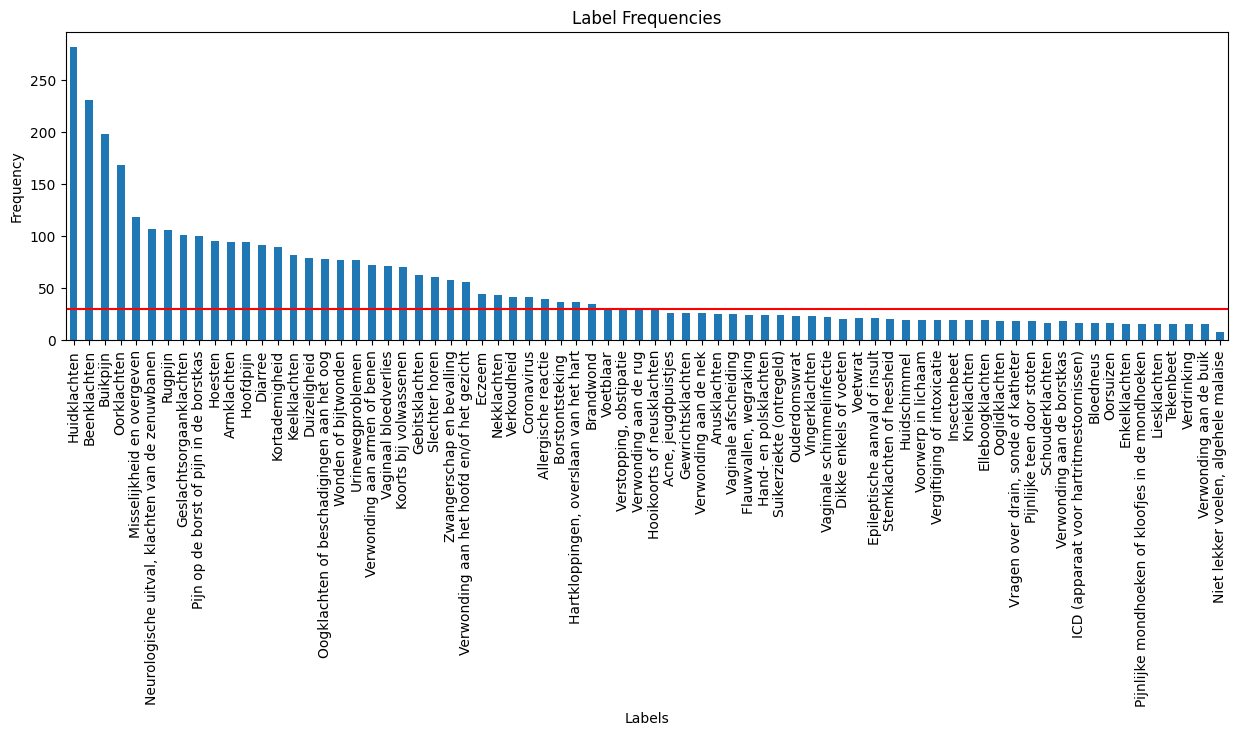

In [13]:
def visualize_frequencies(y, hline=0):
  # Calculate the original frequencies of each label
  label_frequencies_original = df_labels.sum(axis=0).sort_values(ascending=False)

  # Calculate the frequencies
  label_frequencies_new = y.sum(axis=0)

  # Create a df for the frequencies
  df_new_freq = pd.DataFrame(label_frequencies_new, index=df_labels.columns, columns=['frequency'])

  # Sort the frequencies based on the original order
  df_new_freq = df_new_freq.loc[label_frequencies_original.index]

  # Plot the frequencies in descending order based on the original frequencies
  plt.figure(figsize=(15, 4))
  df_new_freq['frequency'].plot(kind='bar')
  plt.title('Label Frequencies')
  plt.xlabel('Labels')
  plt.ylabel('Frequency')
  plt.xticks(rotation=90)
  plt.axhline(y=hline, color='red', linestyle='-')
  plt.show()

visualize_frequencies(y_train, hline=30)

In [14]:
## Handle class imbalance
# Custom oversample minority classes in a multi-label setting
def oversample_X_vectorized(X, y, threshold=35):
    """
    Perform custom oversampling on the minority classes in the dataset.

    Args:
        X (numpy.ndarray): Feature data.
        y (numpy.ndarray): Label data.
        threshold (int): The threshold below which a class is considered a minority class.

    Returns:
        numpy.ndarray: The oversampled feature data.
        numpy.ndarray: The oversampled label data.
    """

    # Identify minority classes
    minority_labels = (y.sum(axis=0) < threshold)
    # Identify instances with minority class labels
    minority_instances = y[:, minority_labels].sum(axis=1) > 0
    # Oversample these instances
    X_oversampled = np.vstack([X[minority_instances]] * 1)
    y_oversampled = np.vstack([y[minority_instances]] * 1)
    # Combine with original data
    X_combined = np.vstack([X, X_oversampled])
    y_combined = np.vstack([y, y_oversampled])
    return X_combined, y_combined

# Apply the oversampling function to training data
X_train_oversampled, y_train_oversampled = oversample_X_vectorized(X_train, y_train, threshold=30)

# Sanity check
assert X_train_oversampled.shape[0] == y_train_oversampled.shape[0], "Mismatch in oversampled train data and labels"
X_train_oversampled.shape, y_train_oversampled.shape

((3907, 5000), (3907, 74))

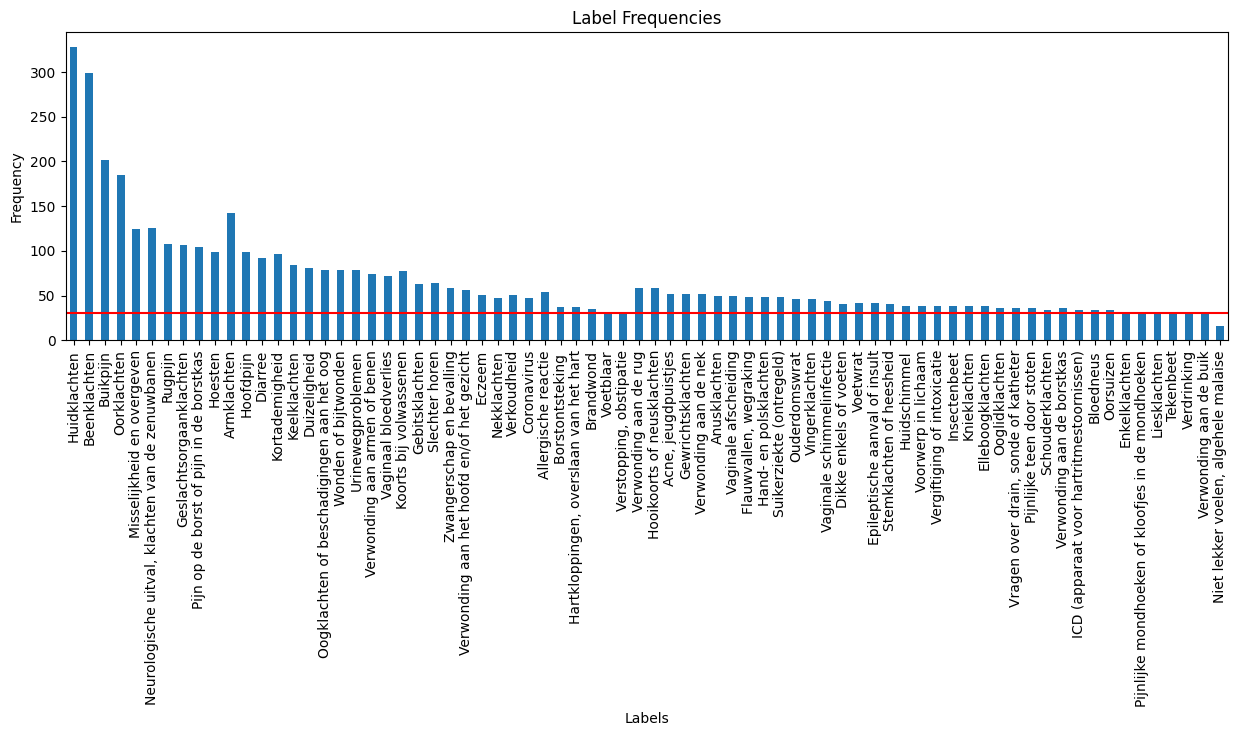

In [15]:
visualize_frequencies(y_train_oversampled, hline=30)